# Лабораторная работа 1
# Фильтр Байеса

В начале помещения находится мобильный робот с координатой 0 в помещении длиной SIZE.  Робот перемещается вдоль одного направления по ячейкам шириной 1 метр. Исполнительные механизмы робота неидеальны, а также присутствует проскальзывание. Вследствие этого, робот перемещеается в заданную ячейку с вероятностью 40%, в соседнюю с ней - с вероятностью 20%, через одну от нее - 10%. Гистограмма погрешности приведена ниже.

<BarContainer object of 5 artists>

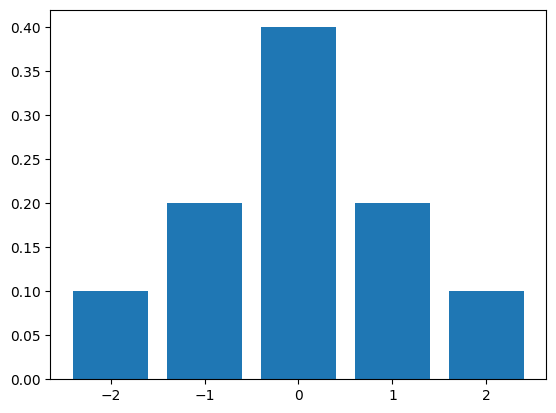

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

robot_errors = [-2, -1, 0, 1, 2]
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(robot_errors, robot_prob)

Положение робота измеряется датчиком с нормальным распределением погрешности, математическое ожидание которой соотвествует положению робота. Рапределение погрешности датчика приведено ниже.

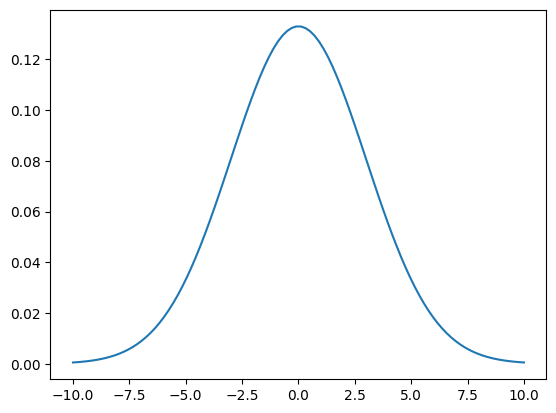

In [ ]:
mu = 0
sigma = 3
x = np.linspace(-10, 10, 100)
p = (2 * np.pi * (sigma ** 2)) ** (-0.5) * np.exp(-0.5 * np.power( x - mu, 2)/ (sigma ** 2))
plt.plot(x, p)


Робот выполняет перемещение в произвольно заданную ячейку $N$. После чего измеряет положение датчиком и применяет фильтр Байеса для уточнения своего положения (данные положения робот может запрашивать сколько потребуется раз). 

## Задание

Требуется:

- Написать программный код, иммитирующий изменение распределения плотности вероятности нахождения робота в ячейках при перемещении (допускается, что робот перемещается в центр ячейки).
- Реализовать функцию, иммитируюущую измерение положения робота датчиком.
- Написать функцию, реализующую фильтр Байеса для определения положения робота.
- Построить график зависимости максимальной вероятности нахождения робота в ячейке от количества измерений.
- Построить график распределения плотности вероятности положения робота после многократных измерений.
- Повторить два предыдущих пункта для трех перемещений при различных среднеквадратических отклонениях показаний датчика.

# Решение задания

In [ ]:
from matplotlib.animation import FuncAnimation
"""
Класс `robot` имитирует перемещение робота и обновление распределения плотности вероятности 
после каждого перемещения или измерения.
"""
class robot:
    def __init__(self, cur = None, N = 0, length = 100, sigma = 3): # инициализирует начальную позицию робота, 
                                                                    # количество перемещений или измерений, 
                                                                    # длину сетки распределения вероятности, 
                                                                    # стандартное отклонение функции плотности Гаусса.
        if cur is None:
            self.cur = int(length/2)
        else:
            self.cur = cur
        self.sigma = sigma
        self.robot_errors_org = np.array([-2, -1, 0, 1, 2])
        self.robot_errors = np.array([-2, -1, 0, 1, 2])
        self.robot_prob = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
        self.N = N
        self.length = length
        self.prior = np.zeros(length) # Распределение до измерения
        self.robot_errors = self.robot_errors+self.cur # Ошибка положения робота
        self.prior[self.robot_errors] =self.robot_prob
        self.posteriors = [self.prior]

    def move(self, u):  # перемещает робота на расстояние u и 
                        # обновляет распределение плотности вероятности на основе вероятности перемещения и 
                        # предыдущего распределения плотности вероятности.
        post = np.zeros_like(self.prior)
        for i in range(-2,3):
            for j in range(3+u,self.length-3+u):
                post[j] += self.robot_prob[i+2]*self.prior[j-u-i]
        post = post/np.sum(post)
        self.prior = post
        self.posteriors.append(post)
        return post
 
    def __p_gause(self, mu = 0): #вычисления функции плотности Гаусса
        sigma = self.sigma
        x = np.arange(-int(self.length/2), int(self.length/2))
        p = (2 * np.pi * (sigma ** 2)) ** (-0.5) * np.exp(-0.5 * np.power( x - mu, 2)/ (sigma ** 2))
        self.measure = p
        return p
    
    def bayes(self, measure): # обновления распределения плотности вероятности
        mul =  self.prior*self.__p_gause(measure)
        self.prior = mul/np.sum(mul)
        posterior = self.prior
        self.posteriors.append(posterior)
        
    def show(self, name = "Nothing"): # для создания анимации
        fig, ax = plt.subplots()                    
        ax.set(xlim=(-self.length, self.length), ylim=(0, np.max(self.posteriors)), title=name)
        ax.set_xlabel("x")
        ax.set_ylabel("p(x)")
        self.line, = ax.plot([], [], lw=3)
        anim = FuncAnimation(fig, self.animate, init_func=self.init, frames=20, interval=80, blit=True)
        anim.save(name+'.gif', writer='matplotlib.animation.PillowWriter')

    def init(self):
        self.line.set_data([], [])
        return self.line,

    def animate(self, i):
        self.line.set_data(np.linspace(-int(self.length/2), int(self.length/2), self.length), self.posteriors[i])
        return self.line,
"""
Функция generate_moves генерирует случайные перемещения робота
"""

def generate_moves(n_moves):  #генерирует случайные перемещения робота
    mat = np.zeros(n_moves)
    for i in range(n_moves):
        mat[i] = np.random.randint(-2,2)
    return mat

"""
Функция movements_demo демонстрирует, как обновляется распределение плотности вероятности при перемещении робота. 
"""
def movements_demo(save = False): 
    myrobot = robot(length = 100)
    moves = generate_moves(1000)
    for move in moves:
        myrobot.move(int(move))
    if save:
        myrobot.show("moving")
"""
Функция generate_measures генерирует случайные измерения.
"""
def generate_measures(n_measures):
    mat = np.zeros(n_measures)
    for i in range(n_measures):
        mat[i] = np.random.randint(-2,2)
    return mat
"""
Функция measurements_demo демонстрирует, как обновляется распределение плотности вероятности при измерении.

"""
def measurements_demo(sigma = 3,N = 40, save = False):
    measures = generate_measures(N)
    myrobot = robot(length = 20, sigma = sigma)
    maxes = []
    for i in range(len(measures)):
        myrobot.bayes(measures[i])
        maxes.append(max(myrobot.posteriors[-1]))
    if save:
        myrobot.show("measurements")
    return maxes
"""
Функция move_measure демонстрирует, как обновляется распределение плотности вероятности при перемещении и измерении. 
"""
def move_measure(sigma = 3,N = 500, save = False): #Генерирует случайные комбинации
    myrobot = robot(length = 50, sigma = sigma)
    measures = generate_measures(N)
    moves = generate_moves(N)
    maxes = []
    ac_sum = 0
    for i in range(N):
        ac_sum += moves[i]
        myrobot.move(int(moves[i]))
        myrobot.bayes(ac_sum)
        maxes.append(np.max(myrobot.posteriors[-1]))
    if save:
        myrobot.show("move_measure")
    return maxes
#measurements_demo()
#movements_demo()
#move_measure()

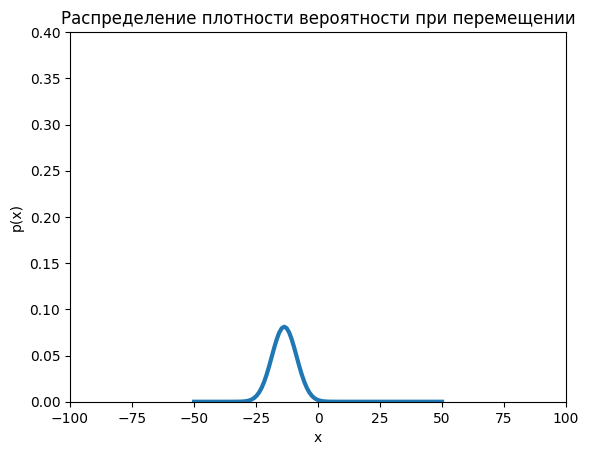

In [ ]:
movements_demo(save = True)

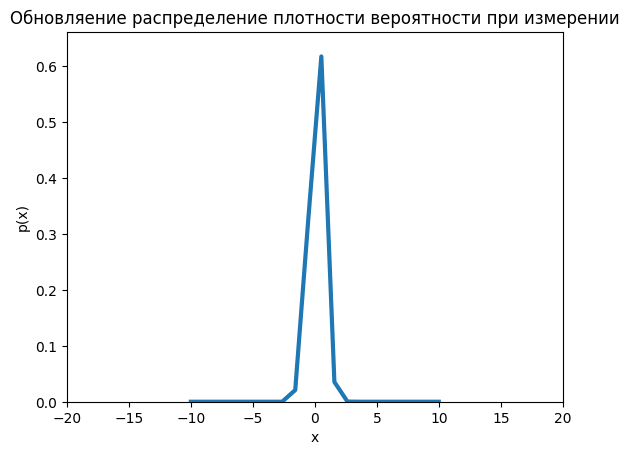

In [ ]:
maxes = measurements_demo(save = True)

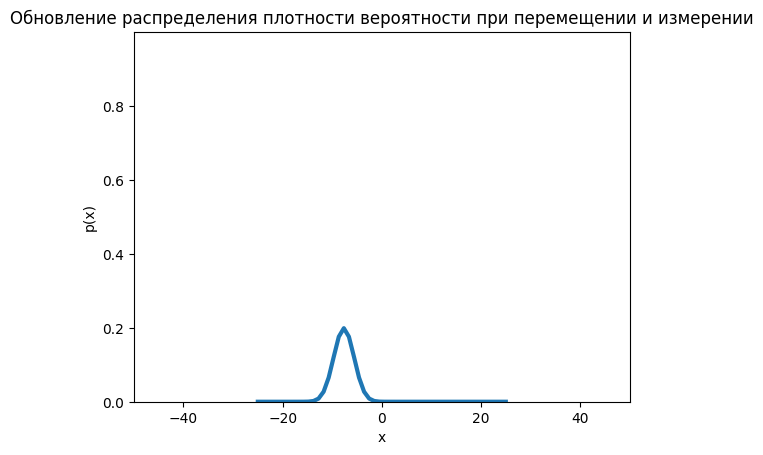

In [ ]:
cords = move_measure(N = 100, save = True)

#Выводы:
В ходе данной работы был написан программный код, иммитирующий изменение распределения плотности вероятности нахождения робота в ячейках при перемещении.

Реализована функция, иммитируюущая измерение положения робота датчиком.

Реализована функция, реализующую фильтр Байеса для определения положения робота.

Построен график зависимости максимальной вероятности нахождения робота в ячейке от количества измерений.

Построен график распределения плотности вероятности положения робота после многократных измерений.